# Tema 13: Shor en 2n+3 qubits

En este notebook vamos a implementar el algoritmo de Shor utilizando una versión optimizada que requiere únicamente 2n+3 qubits, donde n es el número de bits necesarios para representar el número que queremos factorizar. Esta implementación es significativamente más eficiente en términos de recursos cuánticos que las versiones tradicionales del algoritmo, lo que la hace más viable para su ejecución en dispositivos cuánticos reales con un número limitado de qubits.

La reducción en el número de qubits necesarios se logra mediante técnicas avanzadas de optimización del circuito cuántico, incluyendo el uso de estimación de fase cuántica iterativa (IQPE) y una gestión cuidadosa de los registros cuánticos. Esta versión mantiene la capacidad de factorizar números enteros de manera eficiente mientras minimiza los requisitos de hardware cuántico.

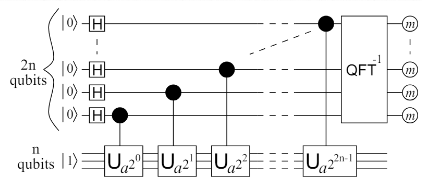

Este notebook implementará el algoritmo de Shor mediante la Quantum Phase Estimation with QFT (QPEwQFT) y mediante la Iterative Quantum Phase Estimation (IQPE).

El paper básico que se sigue en la creación de puertas es: https://arxiv.org/abs/quant-ph/0205095, de Stéphane Beauregard.[1]

Explicación del IQPE:
https://doi.org/10.48550/arXiv.quant-ph/0001066 [2]

Explicación seminario del autor: https://youtu.be/AJqLk4-tzcc

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np
import math
from fractions import Fraction
from qiskit.synthesis.qft import synth_qft_full
from IPython.display import display

def _qft_gate(num_qubits: int, inverse: bool = False, do_swaps: bool = False):
    """Puerta QFT equivalente a QFT deprecada, usando synth_qft_full (misma base que QFTGate). Esto lo hago para que sea legible"""
    circuit = synth_qft_full(num_qubits=num_qubits, do_swaps=do_swaps, inverse=inverse,
                             name="IQFT" if inverse else "QFT")
    return circuit.to_gate()

---
# Funciones del anterior tema

In [2]:
def numbin(a, n):
    '''Funcion que convierte el numero decimal a en uno binario con n bits.

    Parametros:
    a : entero que queremos pasar a binario.
    n : entero del numero de bits que queremos para el binario.
    '''
    a = bin(a)[2:]#[-n:]         #Pasamos el numero a binario
    return '0'*(n-len(a)) + a#Añadimos los ceros a la izquierda necesarios para que tenga el numero de bits.

def m_inv(a, N):
    '''Funcion que implementa a modulo inverso de N.'''
    return pow(a, -1, N)

def primador(p, q, itmax = 100, used_a = []):
    '''Funcion que implementa el crear un numero N a partir de 2 primos
    y nos da un numero a valido para el algoritmo.
    itmax es el numero de iteraciones permitidas para buscar este a.'''
    N   = p * q
    ver = True; itera = 0      #Comprueba que el maximo comun divisor de a y N sea 1.
    while ver and itera<itmax:
        a  = np.random.randint(2, N)#Entero aleatorio entre 2 y N.
        cd = np.gcd(a, N)
        if cd == 1 and (a not in used_a): ver = False
        itera += 1#Contador de iteraciones.
    if ver == True: raise ValueError('No se ha encontrado un a valido.')
    return a, N

def reductor(num, den):
    '''Esta función implementa la obtención de
    la fraccion irreducible de un numero.
    El número de entrada va a ser una fraccion num/den.
    Ambos parametros son enteros.
    Se basa en dividir por el máximo común divisor.'''
    mcd = np.gcd(num, den)
    return num // mcd, den // mcd
    # Otra posible implementacion
    # for i in range(num, 0, -1):
    #     if num % i == 0 and den % i == 0:
    #         num /= i; den /= i
    # return int(num), int(den)

def procesador(counts, a, N, max_mult=None, reverse_bits=False):
    # Ordenar por frecuencia
    sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # t: número de bits medidos (limpiando espacios). Usa el máximo por robustez.
    t = max(len(k.replace(" ", "")) for k in counts.keys())
    # Calcula 2^t usando desplazamiento de bits (equivalente a 2**t pero más eficiente)
    # El operador << desplaza 1 hacia la izquierda t posiciones, multiplicando por 2^t
    two_power_t = 1 << t

    # Cuántos múltiplos probar (por si el denominador recuperado es divisor del orden)
    if max_mult is None:
        max_mult = min(N, 2 * t + 10)

    for key, freq in sorted_items:
        bits = key.replace(" ", "")
        if len(bits) != t:
            # Si hay longitudes distintas, ajusta a t por la izquierda (típico) o ignora
            bits = bits.zfill(t)

        if reverse_bits:
            bits = bits[::-1]

        x = int(bits, 2)
        if x == 0:
            continue

        # Aproximación tipo fracciones continuas: x/2^t ~ s/r0 con r0 <= N
        frac = Fraction(x, two_power_t).limit_denominator(N)
        r0 = frac.denominator
        if r0 <= 0:
            continue

        # Probar múltiplos de r0 y validar el periodo
        for m in range(1, max_mult + 1):
            r = m * r0
            if r > N:
                break

            if pow(a, r, N) != 1:
                continue
            if r % 2 != 0:
                continue

            ar2 = pow(a, r // 2, N)
            if ar2 == N - 1:
                continue

            p = math.gcd(ar2 - 1, N)
            q = math.gcd(ar2 + 1, N)

            if 1 < p < N:
                return p, N // p
            if 1 < q < N:
                return q, N // q

    return 1, 1

---
# Circuito cuántico

Para implementar el circuito cuántico del algoritmo de Shor para factorizar números de la forma 2n+3, seguiremos varios pasos fundamentales tal como se describe en el paper de referencia.

La estrategia general consiste en construir el circuito mediante la composición de múltiples puertas cuánticas especializadas. Cada una de estas puertas realizará una operación específica dentro del algoritmo completo.

Para mantener el código modular y reutilizable, implementaremos cada puerta como una función independiente. Estas funciones tomarán los parámetros necesarios (como el número de qubits, valores clásicos, etc.) y devolverán directamente el objeto de puerta cuántica correspondiente, listo para ser incorporado al circuito principal.

Este enfoque modular nos permitirá:
- Probar cada componente de forma aislada
- Reutilizar las puertas en diferentes partes del circuito
- Facilitar el debugging y la optimización
- Mantener un código más legible y mantenible

A continuación, procederemos a implementar cada una de estas puertas cuánticas fundamentales, comenzando por la puerta de adición en el espacio de Fourier.

## Puerta Adición

La primera puerta que vamos a implementar es la puerta $\phi ADD(a)$, que transforma  $|\phi(b)\rangle$  en  $|\phi(b+a)\rangle$.

Esta será la puerta que haga la suma en el espacio de Fourier.

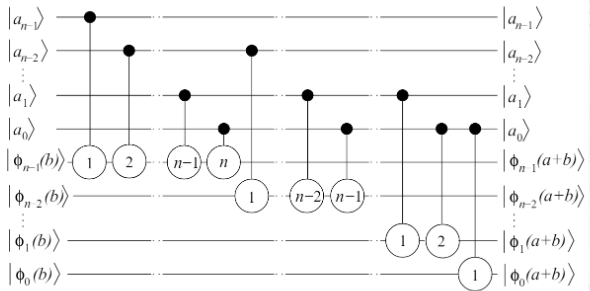

El funcionamiento de esta puerta es el siguiente:

**Entrada y salida de la puerta:**

La entrada que recibe la puerta será la transformada cuántica de Fourier del número $b$, denotada como $|\phi(b)\rangle$, y su salida será $|\phi(b+a)\rangle$. Es decir, la puerta realiza una adición en el espacio de Fourier.

**Parámetro de entrada:**

Su parámetro de entrada será el número $a$ que queramos utilizar, representado en formato binario con $n$ bits. Es fundamental que este número tenga exactamente el mismo número de bits que la entrada $|\phi(b)\rangle$, ya que se establece una correspondencia uno a uno entre los bits de $a$ y los qubits que representan $|\phi(b)\rangle$.

**Representación del número $a$:**

Creamos un grupo de qubits ancilla para representar el número $a$ y los inicializamos (mediante puertas X donde sea necesario) para que codifiquen el estado $|a_{n-1} a_{n-2} \dots a_1 a_0\rangle$, donde los bits $a_k$ son los coeficientes binarios que cumplen la relación $a = \sum_{k=0}^{n-1} a_k 2^{k}$.

**¿Por qué usamos la transformada cuántica de Fourier?**

La razón fundamental para trabajar en el espacio de Fourier es que en este espacio transformado, las operaciones de suma en el espacio estándar se convierten en operaciones de fase. Más específicamente, en el espacio de Fourier, las fases aplicadas a los estados cuánticos corresponden a sumas en el espacio estándar.

Por tanto, agregar una fase apropiada a cada qubit en el estado $|\phi(b)\rangle$ es matemáticamente equivalente a sumar el número $a$ al número $b$ en el espacio estándar. Esta propiedad hace que la adición cuántica sea mucho más eficiente cuando se realiza en el espacio de Fourier, ya que podemos implementarla mediante simples puertas de fase controladas, evitando la necesidad de circuitos de suma clásicos más complejos.

En resumen, la transformada de Fourier convierte el problema de la suma aritmética en un problema de manipulación de fases, lo cual es computacionalmente más ventajoso en el contexto cuántico.

* Tras ello, aplicamos puertas de fase controladas sobre el qbit $|\phi_i\rangle$. Añadiremos controles desde los $|a_j\rangle$ con $j \geq i$ con una fase $\frac{\pi}{2^{j-i}}$. (Una forma de ahorrarse las ancillas y los controles es usar un if, ya que es un número clásico que entra como parámetro.)

* Finalmente restablecemos las ancillas y tenemos el estado $|\phi(b+a)\rangle$.

* Nosotros vamos a implementarlo directamente con puertas de fase de un ángulo igual a la suma ponderada de los ángulos de cada una de las puertas que se aplicarían a ese qubit.

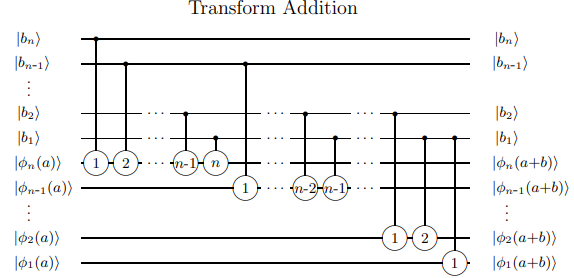

https://arxiv.org/abs/quant-ph/0008033

In [3]:
def ADDER_Gate(n:int, a:int):
    #Sacamos el binario de a
    binario = numbin(a,n)[::-1]#Al reves
    #Creamos el circuito con un registro
    qc = QuantumCircuit(n, name=f'ADD')

    #Hacemos para cada qubit objetivo
    for qubit in range(n):
        angle = 0
        for bit in range(qubit+1):#Para cada bit de a hasta lo necesario
            if binario[bit] == '1':
                angle += 2*np.pi/2**(1+(qubit-bit))

        qc.p(angle, qubit)

    #Creamos la puerta
    Gate = qc.to_gate()

    return Gate

Dibujamos la puerta.

a:2, N:15, n:4


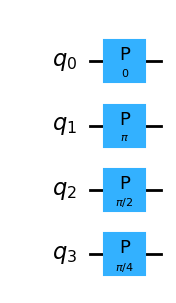

In [4]:
p, q = 3,5
a, N = primador(p, q)
n = int(np.ceil(np.log2(N)))
print(f'a:{a}, N:{N}, n:{n}')

qc = QuantumCircuit(n)
qc.append(ADDER_Gate(n,a), range(n))

qc.decompose(f'ADD').draw('mpl')

Vamos a hacer una prueba.

0010


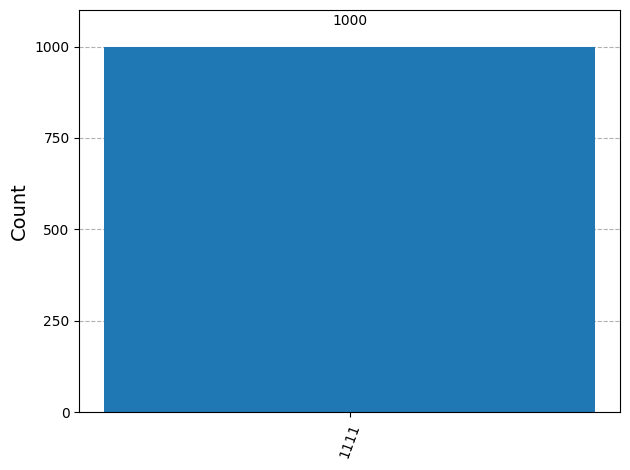

In [5]:
print(numbin(a,n))
w = 37
w %= 2**(n+1)
qc = QuantumCircuit(n)
qc.x(2)
qc.append(_qft_gate(n, do_swaps=False), range(n))
qc.append(ADDER_Gate(n,w).inverse(), range(n))
qc.append(_qft_gate(n, inverse=True, do_swaps=False), range(n))

qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# AerSimulator()  # qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

## Puerta Adición modular condicionada

La segunda puerta que vamos a implementar es la puerta $\phi ADD(a)mod(N)$, que transforma  $|\phi(b)\rangle$  en  $|\phi(b+a)mod(N)\rangle$.

Esta puerta realiza la suma modular en el espacio de Fourier.

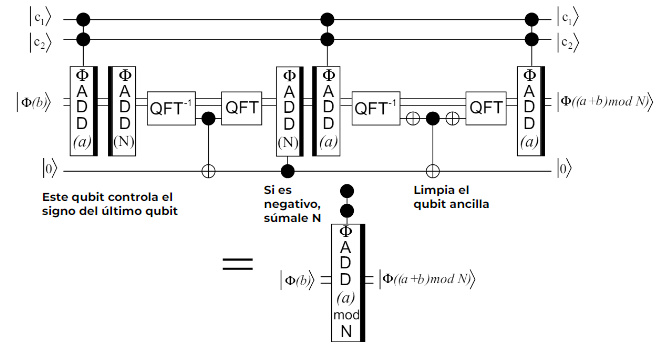

Esta puerta funciona siguiendo la siguiente lógica:

- La entrada será la transformada cuántica de Fourier del número $b$ ( $\phi(b)$ ), y su salida será $\phi(b+a) \mod(N)$.

- Sus parámetros serán $a$ y $N$ en binario. El número $b$ debe tener un bit de más para evitar overflow y poder saber cuál es el signo de cuentas intermedias.

- Primero sumamos $a$ teniendo $\phi(b+a)$ y procedemos a restarle $N$ con la inversa (dagger) de $\phi ADD(N)$, obteniendo $\phi(b+a-N)$.

- Ahora bien, tras esta última operación existe la posibilidad de que el número obtenido sea negativo, si $a+b\leq N$, por lo que miraremos el bit más significativo (el 0), para lo cual primero deberemos invertir la QFT.

- Como necesitamos usar ese bit posteriormente, lo guardamos en una ancilla con una puerta CNOT y rehacemos la QFT para seguir operando.

- Una vez hecho esto, si nuestro número era negativo, necesitamos deshacer la resta de $N$, ya que no queremos números negativos, por lo que usando la ancilla donde pusimos la información del signo, aplicaremos la suma de $N$ de forma controlada por este qubit.

* En principio ya tenemos $\phi(b+a) mod(N)$, pero necesitamos restaurar la ancilla, así que necesitamos saber si hemos restado $N$ anteriormente.
* Para ello restaremos $a$ y desharemos la QFT, lo cual nos dará el número $(a+b)mod N-a$ del cual sacaremos el signo, pero invertido. Esto es debido a que usamos la identidad: $(a+b)mod(N)\geq a \rightarrow (a+b)mod(N)- a \Longleftrightarrow a + b < N$. Por lo tanto, si el número obtenido es positivo será porque antes obtuvimos un número negativo.
* Por tanto, aplicamos una X sobre ese qbit, CNOT desde ese qbit a la ancilla, deshacemos la X, volvemos a QFT y volvemos a sumar la $a$ que habíamos restado.

In [6]:
def cc_Mod_ADDER_Gate(n:int, a:int, N:int):
    #Primero creamos la puerta Add con a y con N
    ADDER_Gate_a = ADDER_Gate(n+1,a%N)#Hay que sumar a mod N
    ADDER_Gate_N = ADDER_Gate(n+1,N)

    #Registros
    control = QuantumRegister(2, name='ctrl')
    state   = QuantumRegister(n+1, name='phi')#Uno extra para el overflow
    sign    = QuantumRegister(1, name='sign')#Ancilla del signo

    qc = QuantumCircuit(control, state, sign, name=f'cc_ADD_mod')

    #Añadimos las puertas de adición controlada y libre
    qc.append(ADDER_Gate_a.control(2), control[:]+state[:])
    qc.append(ADDER_Gate_N.inverse(), state)

    #Comprobamos el signo
    qc.append(_qft_gate(n+1, inverse=True, do_swaps=False), state)
    qc.cx(state[-1], sign[0])
    qc.append(_qft_gate(n+1, do_swaps=False), state)

    #Segunda tanda de sumas
    qc.append(ADDER_Gate_N.control(1), sign[:]+state[:])
    qc.append(ADDER_Gate_a.inverse().control(2), control[:]+state[:])

    #Corregimos la ancilla
    qc.append(_qft_gate(n+1, inverse=True, do_swaps=False), state)
    qc.x(state[-1])
    qc.cx(state[-1], sign[0])
    qc.x(state[-1])
    qc.append(_qft_gate(n+1, do_swaps=False), state)

    #Deshacemos
    qc.append(ADDER_Gate_a.control(2), control[:]+state[:])

    #Descomponemos las QFT
    qc_decomp = qc#.decompose(['QFT', 'IQFT'], reps=1)

    #Transformamos a puerta
    Gate = qc_decomp.to_gate()

    return Gate

Visualizamos.

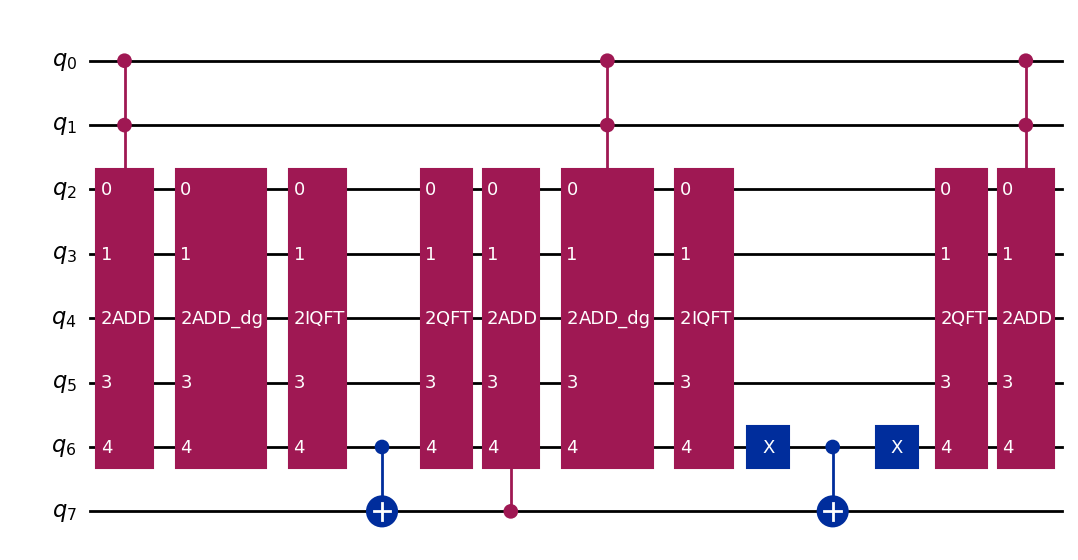

In [7]:
qc = QuantumCircuit(2+n+1+1)
qc.append(cc_Mod_ADDER_Gate(n,a,N), range(n+4))

qc.decompose([f'cc_ADD_mod'], reps=2).draw('mpl')

Probamos.

1010


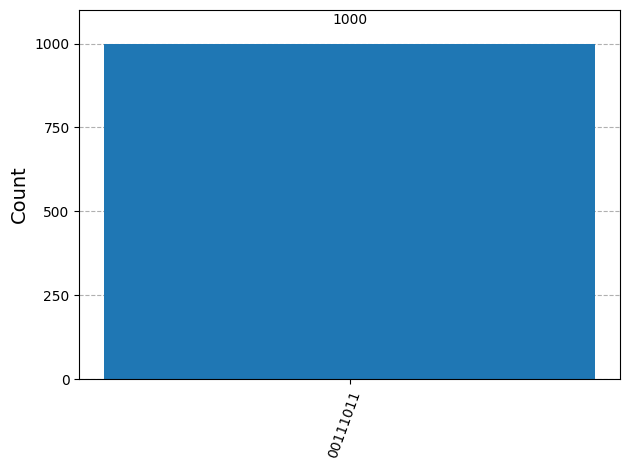

In [8]:
w = 26
print(numbin(w,n)[-n:])
control = QuantumRegister(2, name='ctrl')
state   = QuantumRegister(n+1, name='phi')#Uno extra para el overflow
sign    = QuantumRegister(1, name='sign')#Ancilla del signo

qc = QuantumCircuit(control, state, sign, name=f'cc_ADD_mod')

qc.x(control)#Activamos

qc.x(state[0])
qc.x(state[1])
qc.append(_qft_gate(n+1, do_swaps=False), state)
qc.append(cc_Mod_ADDER_Gate(n,w,N), range(n+4))
qc.append(_qft_gate(n+1, inverse=True, do_swaps=False), state)

qc.measure_all()
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# AerSimulator()  # qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [9]:
b = 3
res = (w+b)%N
print(res)
print(bin(res))

14
0b1110


## Puerta Multiplicación Modular condicionada

La tercera puerta que vamos a implementar es la puerta $\phi CMULT(a)mod(N)$, que transforma  $|x\rangle|\phi(b)\rangle$  en  $|x\rangle|\phi(b+a\cdot x)mod(N)\rangle$.

La puerta que hace la multiplicación.

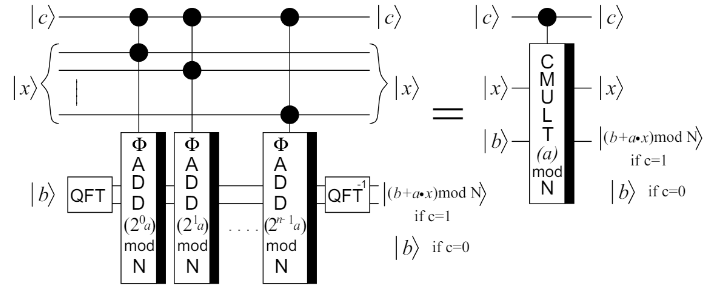

Esta puerta opera de la siguiente manera:
* Su objetivo es convertir $b$ en $(b+a\cdot x)mod(N)$, teniendo como entradas $|x\rangle$ y $|b\rangle$ y los parámetros $a$ y $N$ en forma de binarios. Es importante que $|x\rangle$ tenga el mismo número de qbits que $|b\rangle$, por la siguiente puerta.
* Lo primero que hacemos es transformar el número $b$ en su forma en QFT. Tras ello, vamos aplicando puertas $\phi ADD(2^j a)mod(N)$ sobre $|\phi(b)\rangle$ controladas por los qbits $|x_{n-1-j}\rangle$. La puerta $\phi ADD(2^j a)mod(N)$ significa aplicar $2^j$ veces la puerta $\phi ADD(a)mod(N)$ o aplicarla con el $a$ cambiado.
* Este paso es exactamente igual que la multiplicación usual con números binarios.
* Tras ello deshacemos la QFT y tenemos nuestro resultado.

Recordemos que utilizamos los números de entrada en el espacio estándar solamente en esta puerta, mientras que las que tiene dentro usan los números en el espacio transformado. Esto es debido a que de introducir también las QFT en esas puertas, tendríamos algo de la forma:

$QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}-\dots-QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}$,

donde obviamente las QFT desaparecen con sus inversas, por lo que nos podemos ahorrar todas esas puertas.

In [10]:
def CMULT_Gate(n:int, a:int, N:int):
    #Creamos el circuito con 3 registros
    control = QuantumRegister(1, name='ctrl')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')#El extra es solo abajo
    ancilla = QuantumRegister(1, name='anc')#El ancilla del signo

    qc = QuantumCircuit(control, qx, qb, ancilla, name=f'CMULT')

    #Aplicamos la QFT
    qc.append(_qft_gate(n+1, do_swaps=False), qb)

    #Sumas controladas de cada qubit de x
    for i in range(n):
        qc.append(cc_Mod_ADDER_Gate(n,a*2**i,N), control[:]+[qx[i]]+qb[:]+ancilla[:])

    #QFT inversa
    qc.append(_qft_gate(n+1, inverse=True, do_swaps=False), qb)

    qc_decomp = qc#.decompose(['QFT', 'IQFT'], reps=1)

    #Transformamos a puerta
    Gate = qc_decomp.to_gate()

    return Gate

Visualizamos.

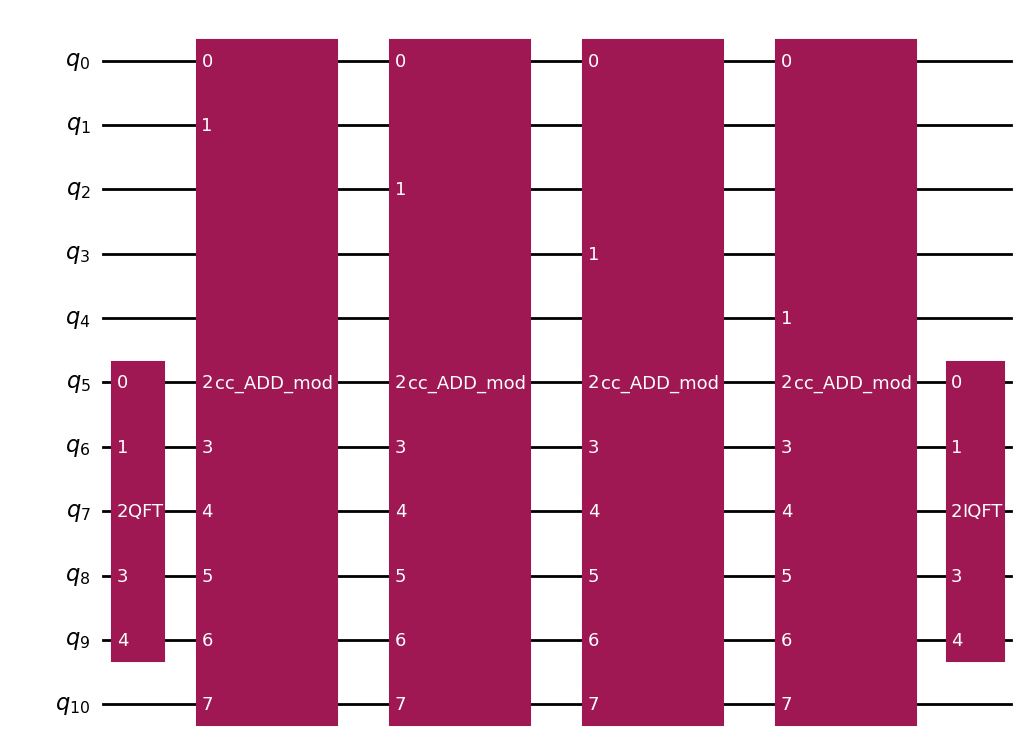

In [11]:
qc = QuantumCircuit(2*n+3)
qc.append(CMULT_Gate(n,a,N), range(2*n+3))

qc.decompose([f'CMULT'], reps=2).draw('mpl')

Probamos

0010


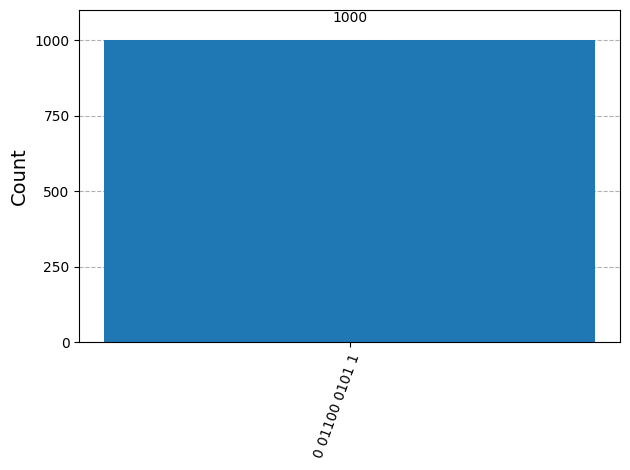

In [12]:
print(numbin(a,n))
control = QuantumRegister(1, name='ctrl')
qx      = QuantumRegister(n, name='x')
qb      = QuantumRegister(n+1, name='b')#El extra es solo abajo
ancilla = QuantumRegister(1, name='anc')#El ancilla del signo

crc = ClassicalRegister(1)
crx = ClassicalRegister(n)
crb = ClassicalRegister(n+1)
cra = ClassicalRegister(1)

qc = QuantumCircuit(control, qx, qb, ancilla, crc, crx, crb, cra)


qc.x(control)#Activamos

qc.x(qx[0])
qc.x(qx[2])

qc.x(qb[1])

qc.append(CMULT_Gate(n,a,N), range(2*n+3))

qc.measure(control,crc)
qc.measure(qx,crx)
qc.measure(qb,crb)
qc.measure(ancilla,cra)

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# AerSimulator()  # qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [13]:
b = 2
x = 5
res = (b+a*x)%N

print(res)
print(bin(res))

12
0b1100


## Puerta U

Finalmente, implementamos la puerta general $U_a$ que nos convierte $|x\rangle$ en $|(a\cdot x)mod(N)\rangle$.

La puerta cuyos autovalores queremos.

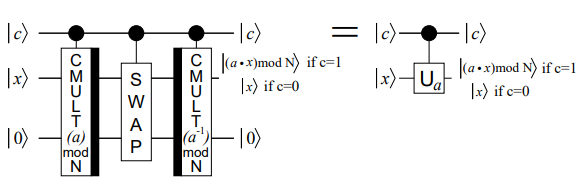

Esta puerta de Shor funciona de la siguiente manera:
* Esta puerta implementa pasar de $x$ a $(a\cdot x)mod(N)$. Su entrada es el vector $|x\rangle$ y los parámetros $a$ y $N$ en entero.
* Vamos a usar una ancilla inicializada a 0 para la parte inferior de la multiplicación (así el factor obtenido estará solamente multiplicado y no tendrá una suma).
* Primero hacemos la multiplicación por a, obteniendo $|x\rangle|(a\cdot x)mod(N)\rangle$.
* Como no queremos nada en la ancilla, aplicamos un SWAP entre la ancilla y la línea principal, obteniendo $|(a\cdot x)mod(N)\rangle|x\rangle$.
* Ahora hacemos la multiplicación por el inverso módulo $N$ de $a$ ($a^{-1}$) teniendo $|(a\cdot x)\rangle|(x- a^{-1}a\cdot x)mod(N)\rangle = |(a\cdot x)mod(N)\rangle|0\rangle$, que es lo que queríamos.

In [14]:
def U_Gate(n:int, a:int, N:int):
    #Cuatro registros como antes
    #Creamos el circuito con 3 registros
    control = QuantumRegister(1, name='ctrl')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    qc = QuantumCircuit(control, qx, qb, ancilla, name=f'U')

    #Multiplicamos
    qc.append(CMULT_Gate(n,a,N), control[:]+qx[:]+qb[:]+ancilla[:])

    #Hacemos todos los SWAPS entre qubits
    for i in range(n):
        qc.cswap(control[0], qx[i], qb[i])

    #Multiplicamos al revés con la inversa modulo N de a
    qc.append(CMULT_Gate(n,m_inv(a,N),N).inverse(), control[:]+qx[::]+qb[::]+ancilla[:])

    Gate = qc.to_gate()

    return Gate

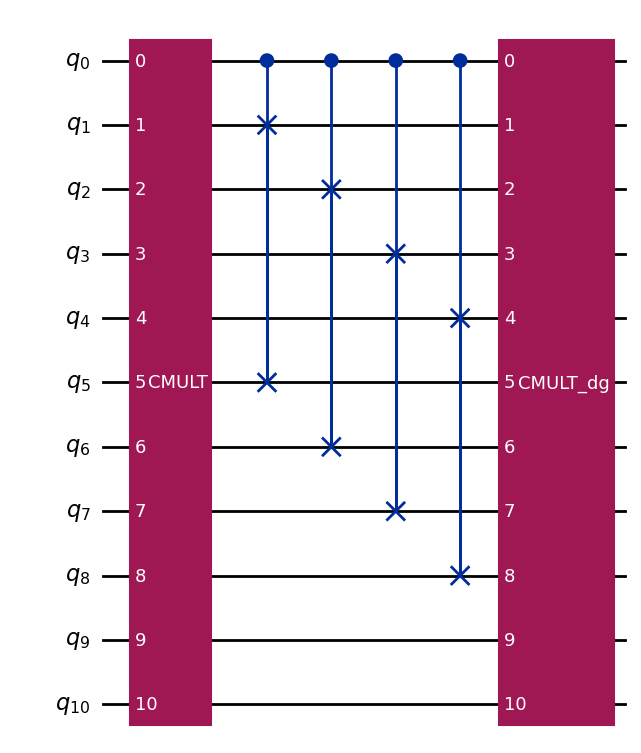

In [15]:
qc = QuantumCircuit(2*n+3)
qc.append(U_Gate(n,a,N), range(2*n+3))

qc.decompose([f'U'], reps=2).draw('mpl')

Hacemos la prueba

0010


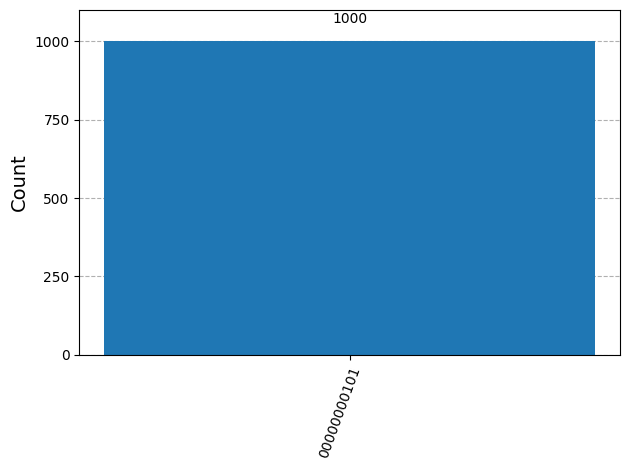

In [16]:
print(numbin(a,n))
control = QuantumRegister(1, name='ctrl')
qx      = QuantumRegister(n, name='x')
qb      = QuantumRegister(n+1, name='b')
ancilla = QuantumRegister(1, name='anc')
qc = QuantumCircuit(control, qx, qb, ancilla)

qc.x(control)#Activamos

qc.x(qx[0])
qc.append(U_Gate(n,a,N), range(2*n+3))

qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# AerSimulator()  # qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [17]:
x = 1
print(a*x%N)
print(numbin(a*x%N,n))

2
0010


## Phase Estimation

Construimos el circuito final.

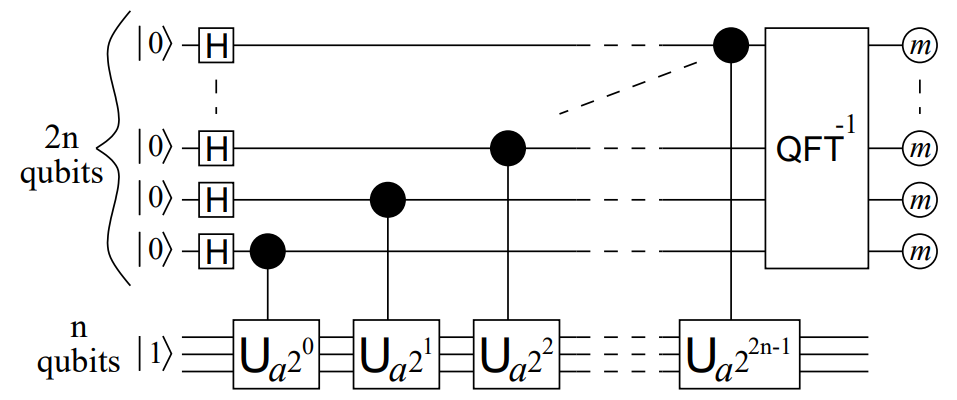

In [18]:
def Shor_Circuit(n:int, a:int, N:int):
    #Registros
    clock   = QuantumRegister(2*n, name='Clock')#para la QFT
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    cr      = ClassicalRegister(2*n, name='measure')

    qc = QuantumCircuit(clock, qx, qb, cr, ancilla, name='Shor')
    #Iniciamos en 1
    qc.x(qx[0])
    #La QPE
    for i in range(2*n):
        qc.h(clock[i])
        qc.append(U_Gate(n, int(a**(2**i)), N), [clock[i]]+qx[:]+qb[:]+ancilla[:])

    #QFT inversa
    qc.append(_qft_gate(2*n, inverse=True, do_swaps=False), clock)
    #Medicion del clock
    qc.measure(clock, cr)

    qc_decomp = qc#.decompose(['QFT', 'IQFT'], reps=1)

    return qc_decomp

Visualizamos.

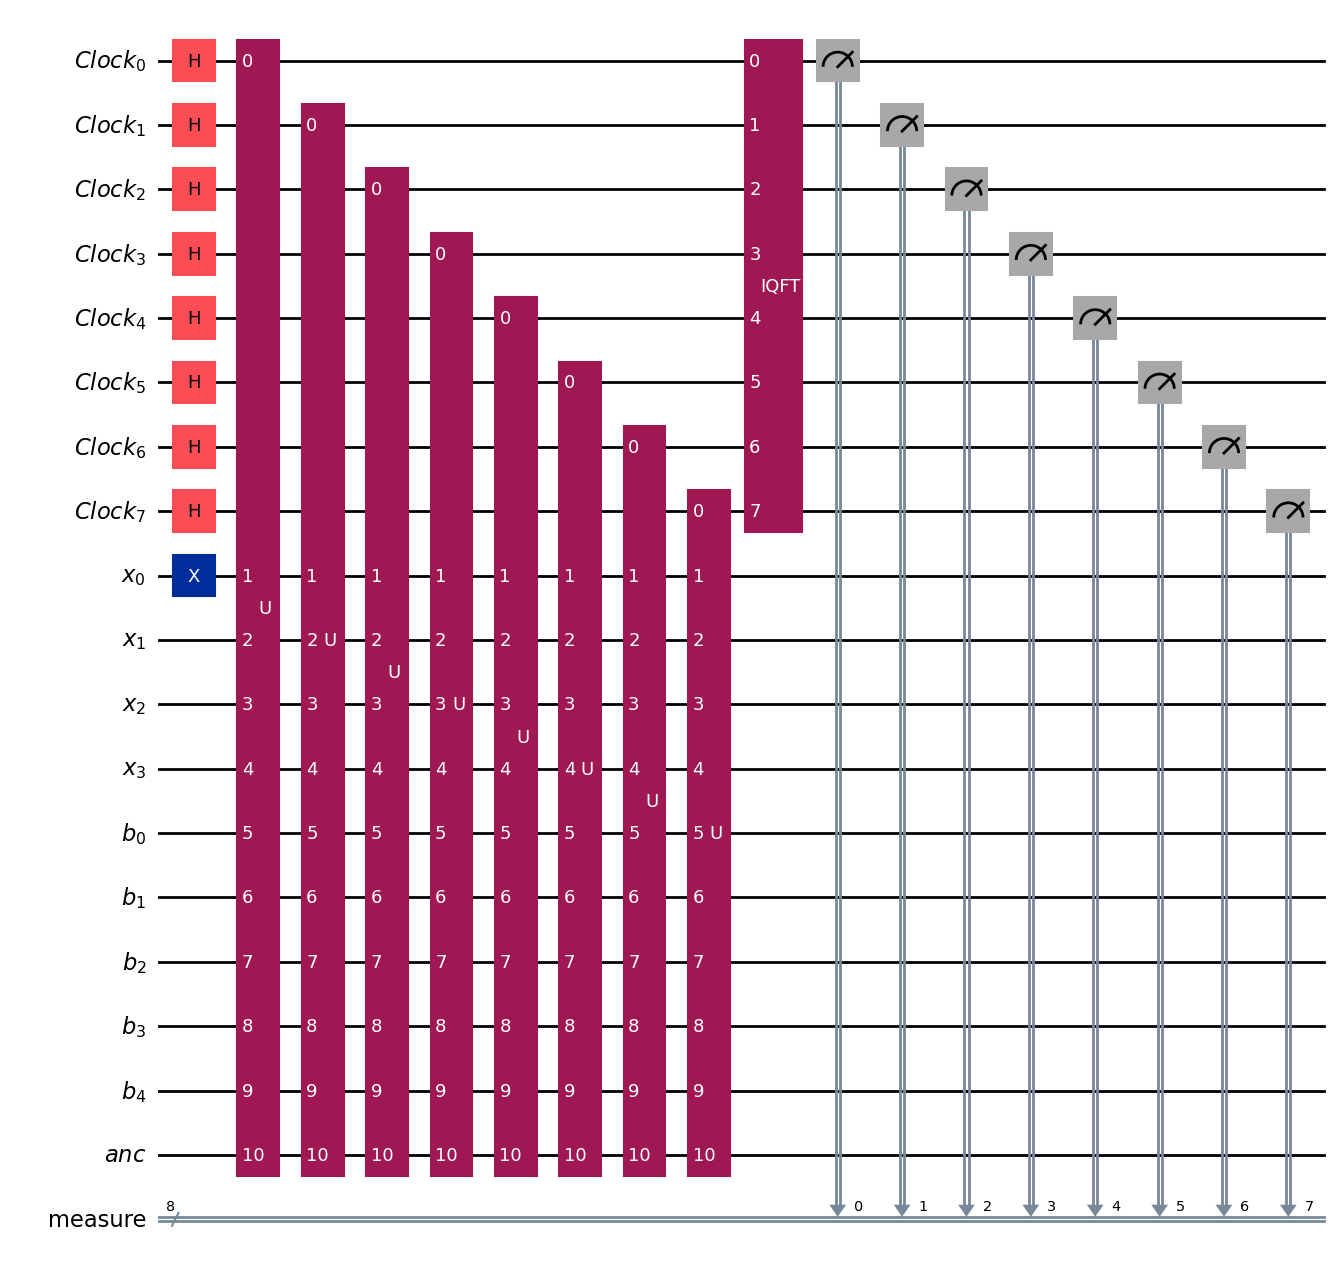

In [19]:
qc = Shor_Circuit(n,a,N)

qc.draw('mpl')

Sin embargo, tenemos que implementar las QPE iterativa concreta de este problema. 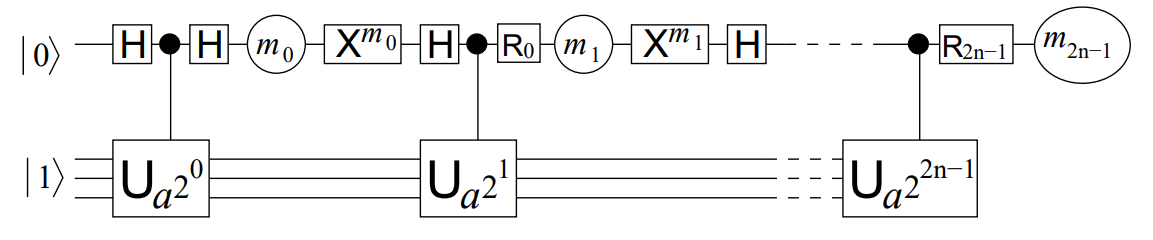

https://arxiv.org/abs/quant-ph/0001066

In [20]:
def Shor_Iterative_Circuit(n:int, a:int, N:int):
    #Registros
    clock   = QuantumRegister(1, name='Clock')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    #Necesitamos varios registros también para el tema de las puertas de fase
    cr      = ClassicalRegister(2*n, name='measure')

    qc = QuantumCircuit(clock, qx, qb, cr, ancilla, name='Shor')
    #Iniciamos en 1
    qc.x(qx[0])
    #La QPE
    for i in range(2*n):
        qc.h(clock)
        qc.append(U_Gate(n, int(a**(2**(2*n-1-i))), N), clock[:]+qx[:]+qb[:]+ancilla[:])#Va al reves la exponenciacion por el paper original
        #Puerta condicionada de las mediciones anteriores
        for k in range(1,i):
            with qc.if_test((cr[i-k],1)):
                qc.p(-2*np.pi/2**k, clock)

        qc.h(clock)
        qc.measure(clock,cr[i])
        #La corrección de la iteración
        with qc.if_test((cr[i],1)):
            qc.x(clock)

    return qc

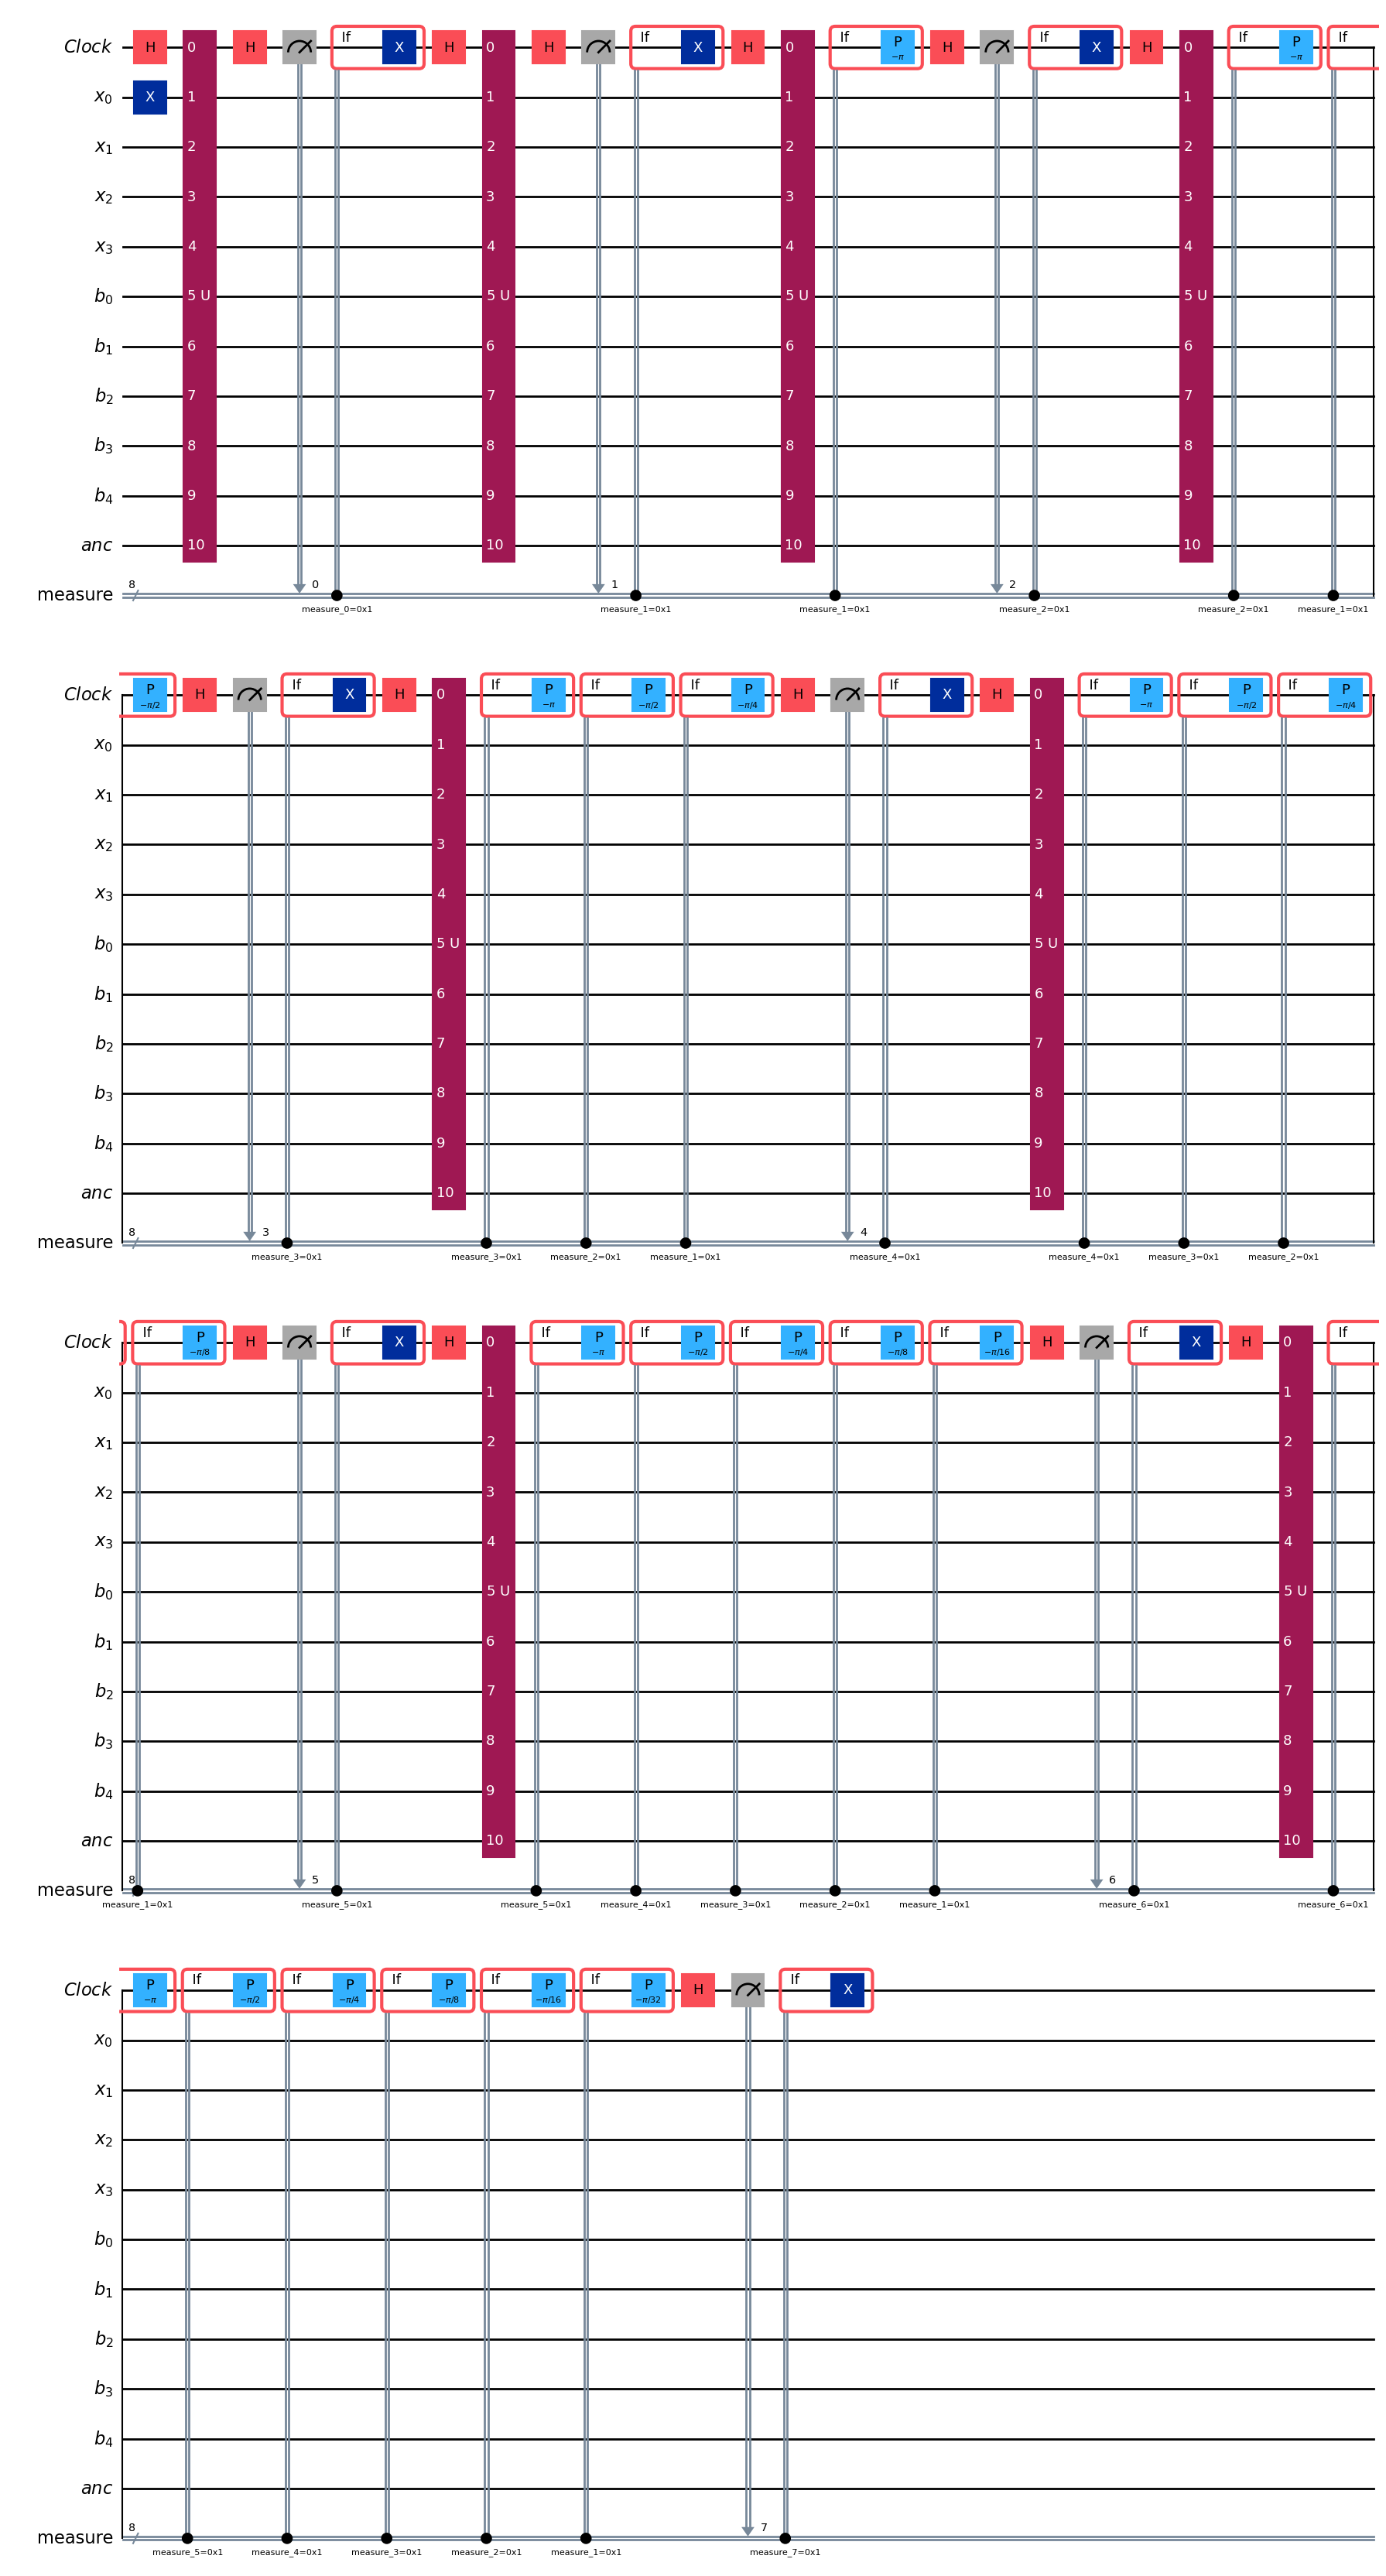

In [21]:
qc = Shor_Iterative_Circuit(n, a, N)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

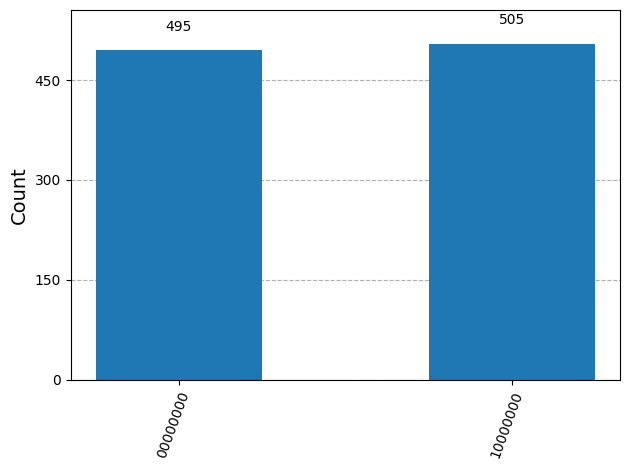

In [23]:
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator(device='CPU', max_parallel_shots=0, max_parallel_threads=0)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos el periodo.

---
# Factorizando un número.

Vamos a probar a juntar todo lo que hemos hecho para factorizar el número 33 = 3 * 11. En este caso, n=6, por lo que necesitaremos 15 qubits, algo asumible. Para ello vamos a crear una función que realice todo el algoritmo.

---
El algoritmo de Shor es un algoritmo que permite factorizar el número $N =p \cdot q$ en los números primos $p$ y $q$ en un tiempo polinómico mediante técnicas de computación cuántica.

El algoritmo procede de la siguiente manera:

### **Parte clásica**

* Elegir un número aleatorio $a$ entre $2$ y $N-1$.
* Calcular $mcd(a, N)$ (máximo común divisor).
Si $mcd(a, N) \neq 1$, este número es un factor no trivial de $N$ y hemos acabado.
* Si $mcd(a, N) = 1$, usamos la parte cuántica para encontrar r, el período de la función:
$f(x)=a^{x}{\bmod {N}}$.
* Este r es el entero positivo más pequeño r para el cual $f(x+r)=f(x)$.
* Si r es impar, volvemos al paso 1 (porque necesitamos su mitad).
* Si $a^{r/2} = -1({\bmod {N}})$, volvemos al paso 1.
Sino, ambos $mcd(a^{r/2}+1,N)$ y $mcd(a^{r/2}-1,N)$ son factores no triviales de N, los primos que queremos.

### **Parte Cuántica**
Hay 2 posibilidades que estudiaremos más adelante, pero conceptualmente se basa en estudiar los autovalores del operador $U_a$ que nos convierte $|x\rangle$ en $|(a\cdot x)mod(N)\rangle$. Este operador unitario introduce una fase en dichos estados, la cual podemos medir con métodos de quantum phase estimation y nos permite obtener la periodicidad de la función $f(y)=a^{y}{\bmod {N}}$.

La idea reside en que vamos a calcular con una superposición de estados que entrelazaremos con el autoestado.

Como vamos a estudiar $f(y)=a^{y}{\bmod {N}}$, haremos que el estado de entrada sea $|1\rangle$, ya que es el autoestado de este operador.

In [22]:
def factorizador(p,q, n_intentos=10, print_histogram=False):
    #Para el numero de qubits
    a, N = primador(p, q, used_a = [])
    n = int(np.ceil(np.log2(N)))
    print('n=', n)
    #Número de shots
    n_shots = 100
    #Simulador de 2n+3 qubits
    backend = AerSimulator(device='CPU', max_parallel_shots=0, max_parallel_threads=0, max_parallel_experiments=0)

    used_a = []
    #Buscamos a
    for i in range(n_intentos):
        a, N = primador(p, q, used_a = used_a)
        used_a.append(a)
        #Hacemos el circuito
        qc = Shor_Iterative_Circuit(n, a, N)

        #Transpilamos
        qc_transpiled = transpile(qc, backend)

        #Creamos el job con más shots para más precisión
        job = backend.run(qc_transpiled, shots=n_shots)

        #Obtenemos el resultado y sus cuentas
        counts = job.result().get_counts()
        if print_histogram:
            display(plot_histogram(counts))

        #Procesamos la salida
        p_obt, q_obt = procesador(counts, a, N)

        if (p_obt != 1 and p_obt != N) or (q_obt != 1 and q_obt != N):#Paramos
            print(f'\rIntentos necesitados: {i+1}. a = {a}')
            return p_obt, q_obt
            break
        else:
            print(f'\rIteración {i} fallida. a={a}', end='')

Lo probamos.

n= 4


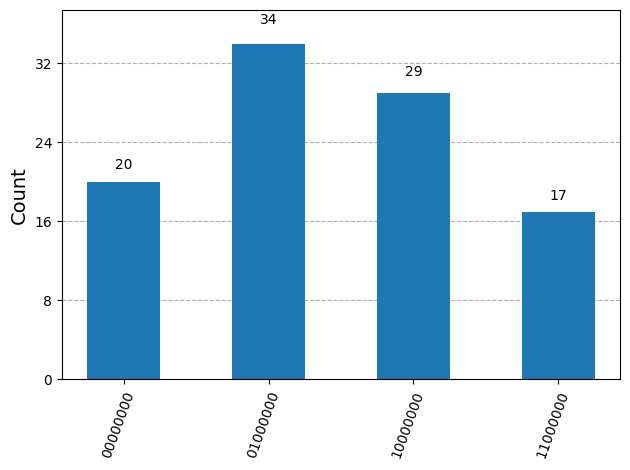

Intentos necesitados: 1. a = 7


In [23]:
p = 3
q = 5

p_obt, q_obt = factorizador(p,q, print_histogram=True)

n= 5


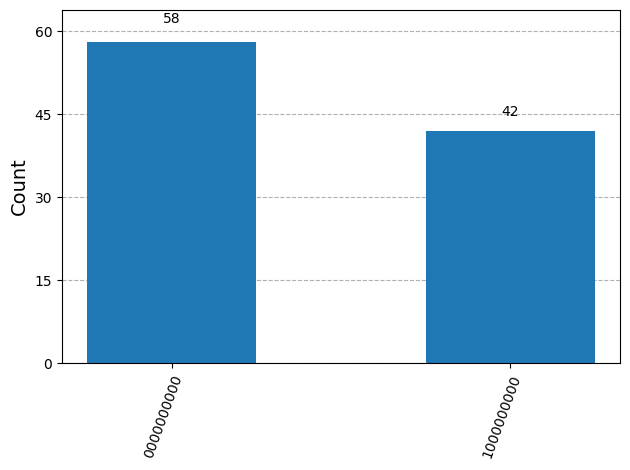

Iteración 0 fallida. a=20

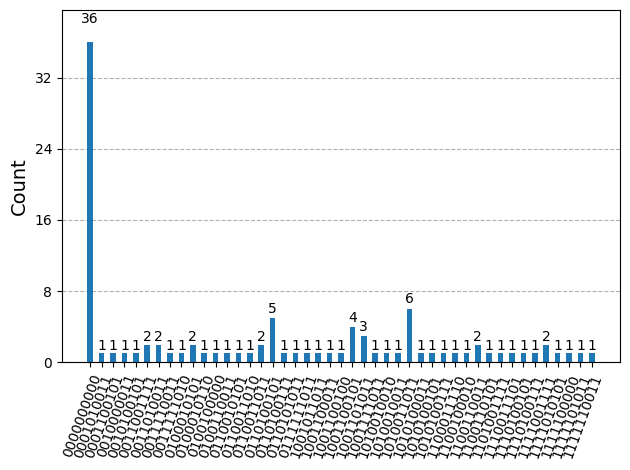

Iteración 1 fallida. a=16

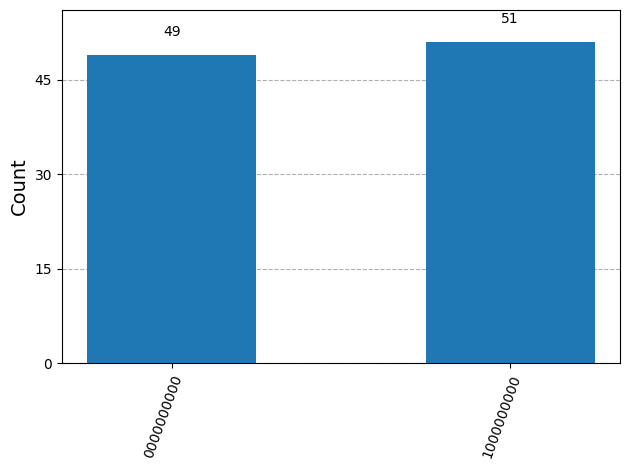

Intentos necesitados: 3. a = 8


In [24]:
p = 3
q = 7

p_obt, q_obt = factorizador(p,q, print_histogram=True)

n= 6


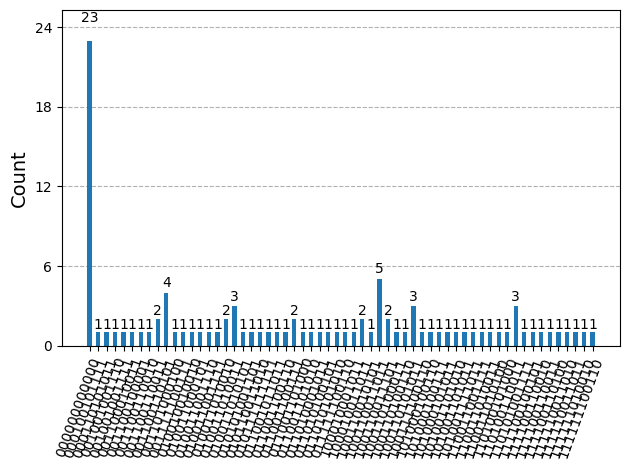

Iteración 0 fallida. a=16

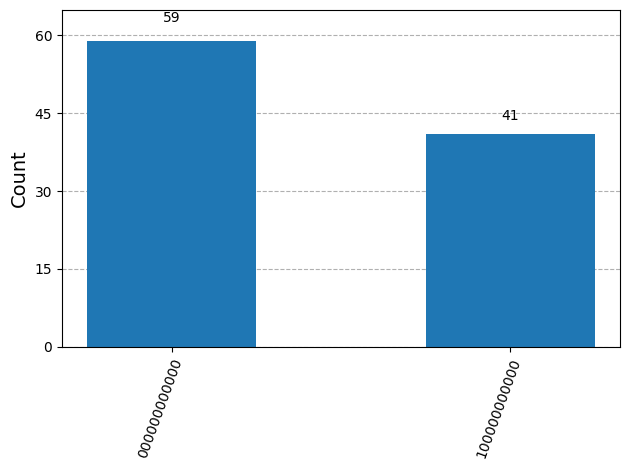

Iteración 1 fallida. a=34

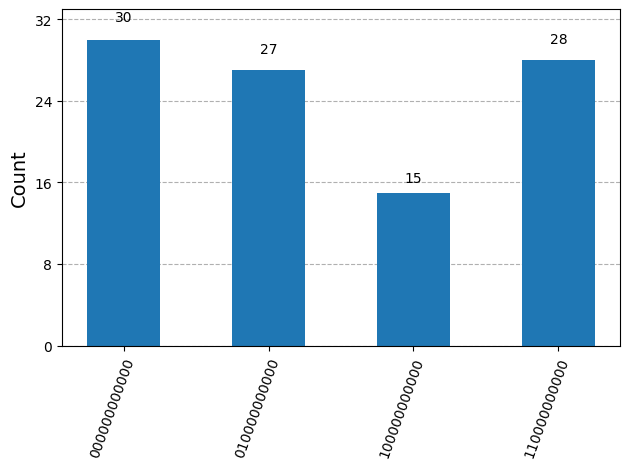

Intentos necesitados: 3. a = 13


In [25]:
p = 5
q = 7

p_obt, q_obt = factorizador(p,q, print_histogram=True)

n= 7


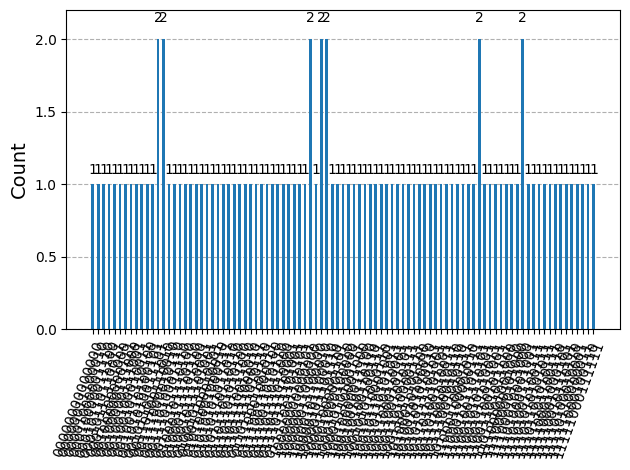

Intentos necesitados: 1. a = 46


In [27]:
p = 7
q = 11

p_obt, q_obt = factorizador(p,q, print_histogram=True)

---
# Ejercicio avanzado (Cuidado con el ordenador)

Prueba a factorizar el número 187 (11*17). Requiere n= 8, un total de 19 qubits para el algoritmo. También puedes probar con 713 (23*31), que son n=10, 23 qubits.

In [ ]:
p = 11
q = 17

p_obt, q_obt = factorizador(p,q)

n= 8


In [ ]:
p = 23
q = 31

p_obt, q_obt = factorizador(p,q)